In [1]:
# Import packages 
import pandas as pd
import numpy as np
from os.path import join
import joblib
import matplotlib.pyplot as plt
import pickle

# We add the github package to our system path so we can import python scripts for that repo. 
import sys
sys.path.append('/home/samuel.varga/python_packages/verification_diagrams')


from verification_diagrams._plot import plot_verification
import itertools
from verification_diagrams import sklearn_curve_bootstrap, VerificationDiagram
from verification_diagrams import brier_skill_score
from verification_diagrams._curve_utils import sklearn_curve_bootstrap
from verification_diagrams._metrics import reliability_uncertainty, brier_skill_score, bss_resolution, max_csi, _binary_uninterpolated_average_precision, bss_reliability 
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from sklearn.metrics._base import _average_binary_score 
from functools import partial

In [19]:
sys.path.append('/home/samuel.varga/projects/deep_learning/')
from deep_learning.training_utils import load_rotation
%matplotlib inline

In [45]:
target_column = 'any_severe__36km'
X_test, y_test = load_rotation(join('/work/samuel.varga/data/2to6_hr_severe_wx/DEEP_LEARNING/',f'wofs_dl_severe__2to6hr__testing_data'), None, target_column)
print(np.shape(y_test))
print(np.shape(y_test.flatten()))

(3410, 16, 16)
(872960,)


In [10]:
out_path = '/work/samuel.varga/projects/2to6_hr_severe_wx/DEEP_LEARNING/results/'
result_path = f'{target_column}_Rot_0_16_16_lrate_0.0001_spatial_dropout_0.1_filters_[64, 128, 256, 512]_size_[2, 1, 2, 1]_pool_[2, 2, 2, 2]_results.pkl'
results = pd.read_pickle(join(out_path, result_path))

In [7]:
results.keys()

dict_keys(['args', 'predict_val', 'predict_val_eval', 'predict_test', 'predict_test_eval', 'predict_train', 'predict_train_eval', 'history', 'fname_base'])

# Performance Diagram

In [38]:
import xarray as xr
meta = xr.open_dataset(join('/work/samuel.varga/data/2to6_hr_severe_wx/DEEP_LEARNING','wofs_dl_severe__2to6hr__testing_meta') , engine='netcdf4')

In [50]:
groups = np.repeat(meta['init_time'].values, 16*16) 
def init_time_to_groups(init_times):
    '''Converts init times to four groups separated by 4 hours'''
    init_times=init_times.astype(int)/100 #Divide by 100 to remove trailing zeros
    init_times = init_times % 4
    return init_times
groups = init_time_to_groups(groups)
print(len(groups))

872960


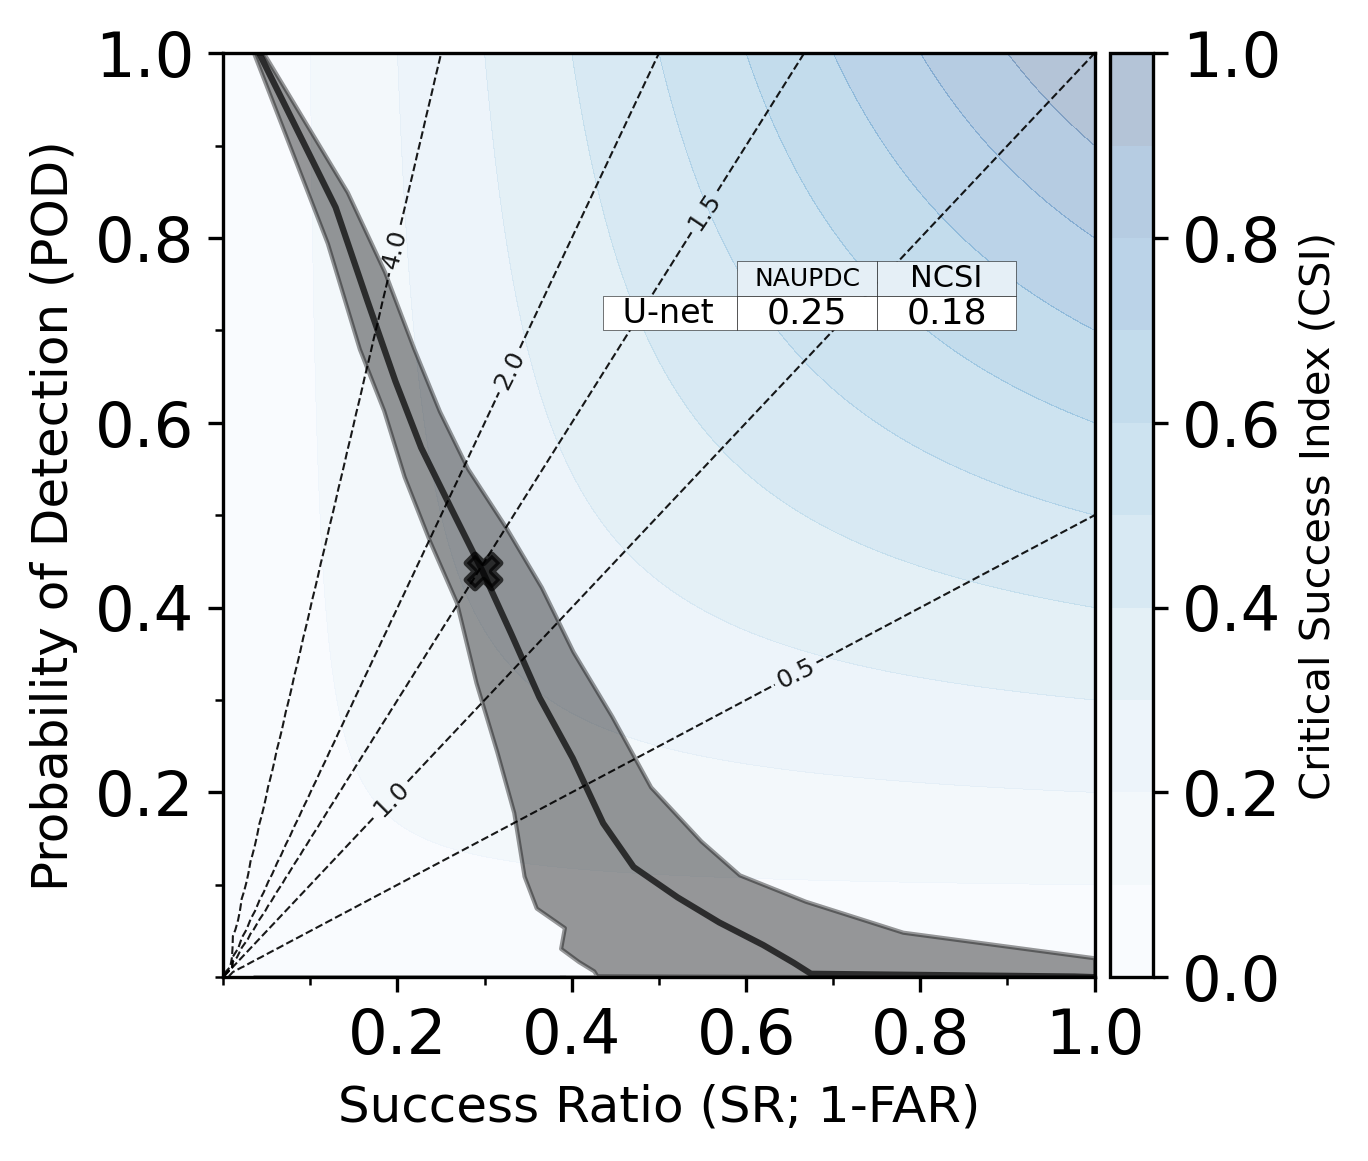

In [61]:
_xx={}
_yy={}
_scores={}
scores={'U-Net':{}}
xx, yy, score = sklearn_curve_bootstrap(y_test.flatten(), results['predict_test'].flatten(), metric='performance', 
                                         n_boot=30, groups=groups, 
                            random_seed=42)
_scores[name]=score
for metric in score:
    scores['U-Net'][metric]=np.nanmean(score[metric])
_xx[name]=xx
_yy[name]=yy
vd = VerificationDiagram()

ax = vd.plot('performance', _xx, _yy, scores=_scores,  add_dots=False, 
             add_max_marker=True, table_fontsize=8,  table_alpha=1, line_colors=['k'],
            plot_kwargs={'line_colors':'k'},
             #table_bbox=[0.75, 0.65, 0.25, 0.4]
            )
plt.show()

# Reliability Diagram

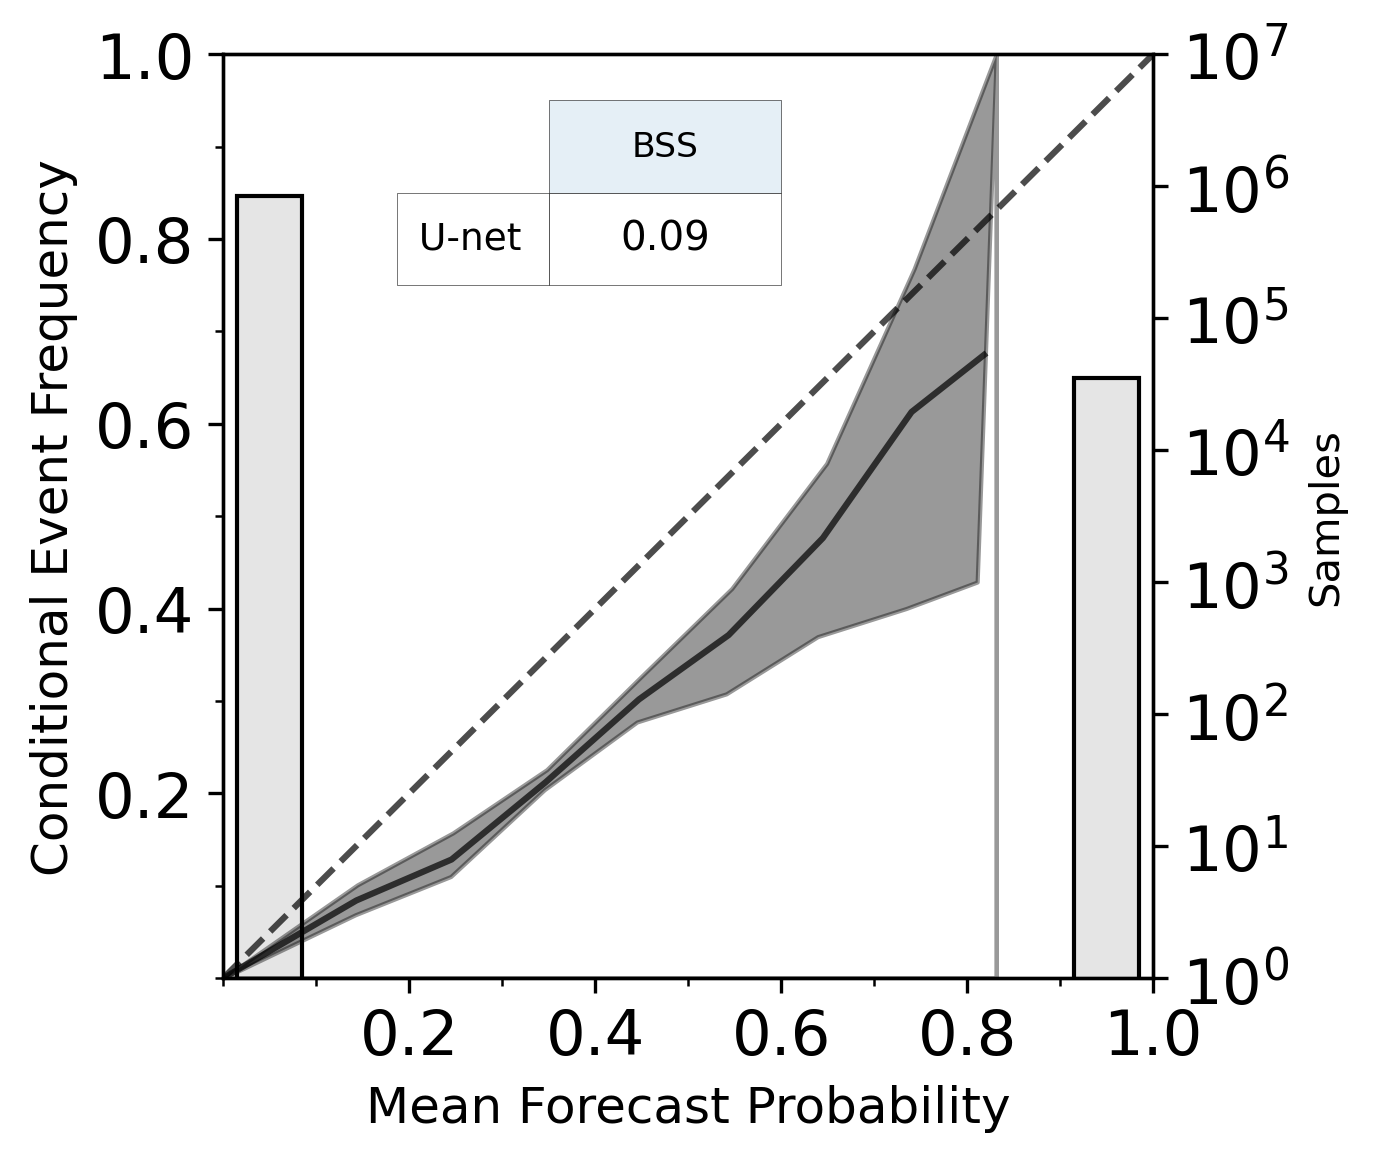

In [62]:
_xx={}
_yy={}
_scores={}
scores={'U-Net':{}}
xx, yy, score = sklearn_curve_bootstrap(y_test.flatten(), results['predict_test'].flatten(), metric='reliability', 
                                         n_boot=30, groups=groups, 
                            random_seed=42)
_scores[name]=score
for metric in score:
    scores['U-Net'][metric]=np.nanmean(score[metric])
_xx[name]=xx
_yy[name]=yy

vd = VerificationDiagram(y_pred=y_test.flatten())
ax = vd.plot('reliability', _xx, _yy, scores=_scores, 
             #table_bbox=[0.46, 0.65, 0.1, 0.4],
             table_bbox=[0.35, 0.75, 0.25, 0.2],
             line_colors=['k'], #0.28
            plot_kwargs={'line_colors':['k']},table_fontsize=9, table_alpha=1, add_dots=False)

plt.show()

(array([6.46074e+05, 7.36880e+04, 3.97420e+04, 2.58380e+04, 2.03650e+04,
        1.57560e+04, 1.25300e+04, 1.03370e+04, 8.56100e+03, 7.24500e+03,
        4.33600e+03, 2.99100e+03, 2.11500e+03, 1.55600e+03, 1.03900e+03,
        6.03000e+02, 1.63000e+02, 2.10000e+01, 0.00000e+00, 0.00000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

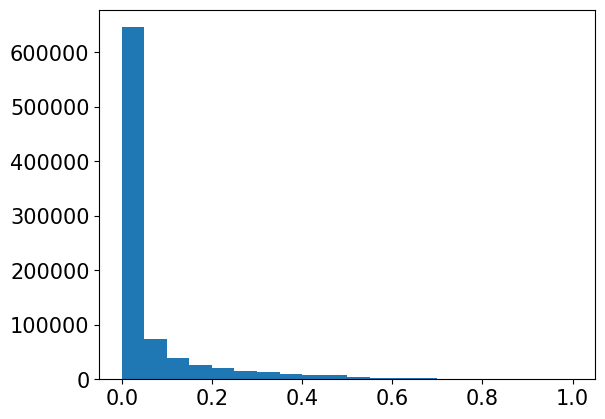

In [63]:
plt.hist(results['predict_test'].flatten(), bins=np.arange(0,1.01,0.05))

# ROC Curve

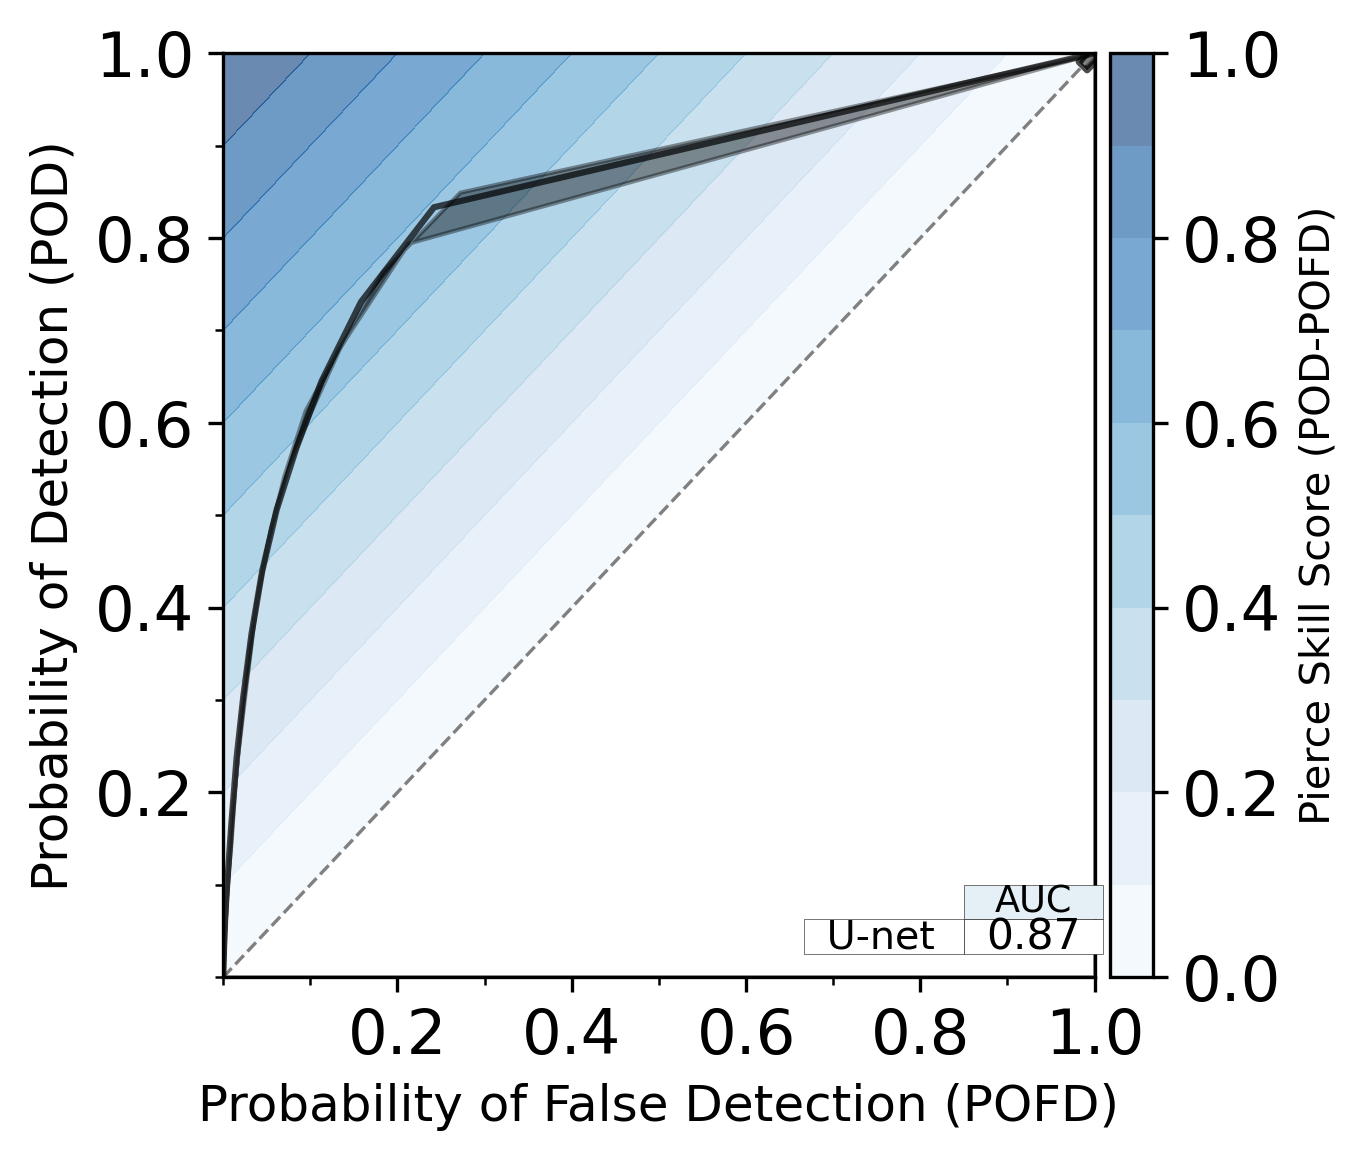

In [64]:
_xx={}
_yy={}
_scores={}
scores={'U-Net':{}}
xx, yy, score = sklearn_curve_bootstrap(y_test.flatten(), results['predict_test'].flatten(), metric='roc', 
                                         n_boot=30, groups=groups, 
                            random_seed=42)
_scores[name]=score
for metric in score:
    scores['U-Net'][metric]=np.nanmean(score[metric])
_xx[name]=xx
_yy[name]=yy

vd.plot('roc', _xx, _yy, scores=_scores, add_dots=False, add_max_marker=True, plot_kwargs={'line_colors':['k']},table_fontsize=9.5, table_alpha=1 )

plt.show()